In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv')
df

,Unnamed: 0,locality,category_main_cb,furnished,object_type,parking_lots,price_summary_unit_cb,locality_street_id,terrace,balcony,...,low_energy,easy_access,building_condition,locality_country_id,garage,room_count_cb,energy_efficiency_rating_cb,price_summary_czk,garden_area,estate_area
0,0,"Maiselova, Praha 1 - Josefov",1.0,2.0,0.0,0.0,2.0,120458.0,0.0,1.0,...,0.0,0.0,1.0,112.0,0.0,0.0,7.0,35000.0,NaN,NaN
1,1,"Opatovická, Praha 1 - Nové Město",1.0,3.0,0.0,0.0,2.0,121234.0,1.0,1.0,...,0.0,0.0,9.0,112.0,0.0,0.0,3.0,49500.0,NaN,NaN
2,2,"Grafická, Praha 5 - Smíchov",1.0,1.0,0.0,1.0,2.0,119641.0,1.0,0.0,...,1.0,1.0,6.0,112.0,1.0,0.0,1.0,32500.0,NaN,NaN
3,3,"Holečkova, Praha 5 - Košíře",1.0,1.0,0.0,0.0,2.0,119726.0,0.0,0.0,...,0.0,0.0,1.0,112.0,0.0,1.0,7.0,33000.0,NaN,NaN
4,4,"Na zátorách, Praha 7 - Holešovice",1.0,1.0,0.0,0.0,2.0,120960.0,0.0,1.0,...,0.0,1.0,1.0,112.0,0.0,0.0,0.0,10158.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3655,3655,"Řeporyjská, Praha 5 - Jinonice",1.0,2.0,0.0,1.0,2.0,121745.0,0.0,0.0,...,0.0,0.0,6.0,112.0,1.0,0.0,3.0,23000.0,NaN,NaN
3656,3656,"Na Poříčí, Praha 1 - Nové Město",1.0,3.0,0.0,1.0,2.0,120809.0,1.0,0.0,...,0.0,0.0,1.0,112.0,1.0,0.0,7.0,75000.0,NaN,NaN
3657,3657,"náměstí Jiřího z Poděbrad, Praha 3 - Vinohrady",1.0,0.0,0.0,0.0,2.0,122964.0,0.0,0.0,...,0.0,0.0,2.0,112.0,0.0,0.0,0.0,40609.0,NaN,NaN
3658,3658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
df.isna().sum()

Unnamed: 0                        0
locality                          3
category_main_cb                  3
furnished                         3
object_type                       3
parking_lots                      3
price_summary_unit_cb             3
locality_street_id                3
terrace                           3
balcony                           3
locality_district_id              3
locality_ward_id                  3
loggia                            3
category_sub_cb                   3
building_type                     3
elevator                          3
locality_gps_lat                  3
basin                             3
locality_region_id                3
category_type_cb                  3
hash_id                           3
cellar                            3
object_kind                       3
locality_gps_lon                  3
usable_area                       3
locality_quarter_id               3
ownership                         3
locality_municipality_id    

In [3]:
df.drop(['garden_area', 'estate_area'], inplace=True, axis=1)

df.dropna(inplace=True)

<Axes: xlabel='locality_gps_lon', ylabel='locality_gps_lat'>

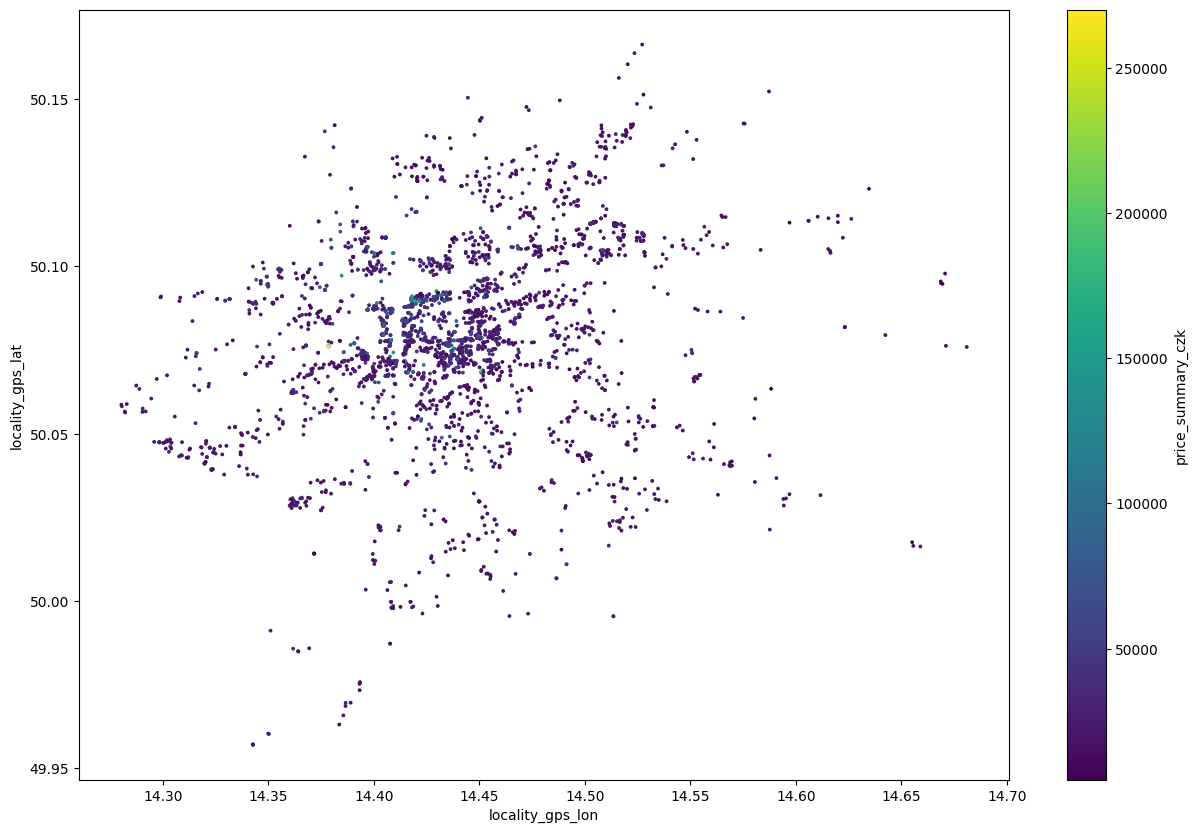

In [4]:
df.plot(kind='scatter', x='locality_gps_lon', y='locality_gps_lat', figsize=(15, 10), c="price_summary_czk" , colormap='viridis', s=3)

<Axes: xlabel='locality_gps_lon', ylabel='locality_gps_lat'>

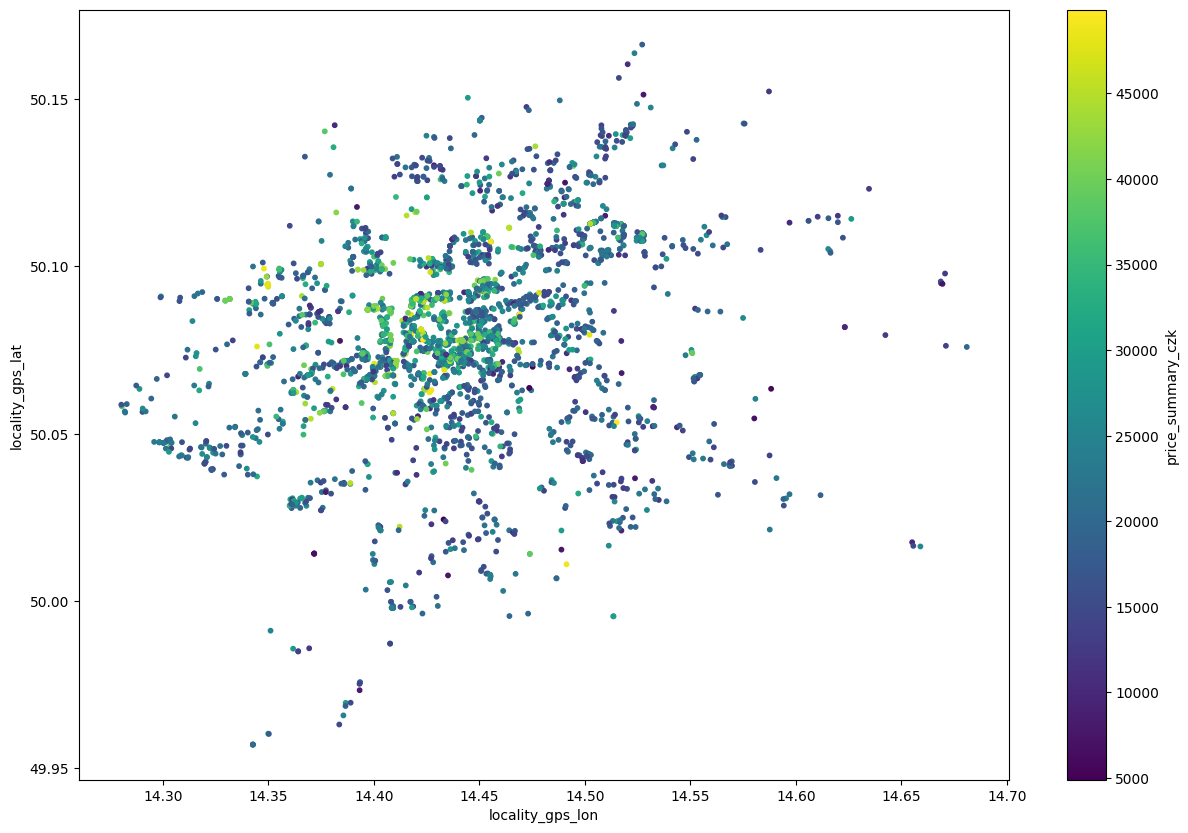

In [5]:
df[df['price_summary_czk'] < 50000].plot(kind='scatter', x='locality_gps_lon', y='locality_gps_lat', figsize=(15, 10), c="price_summary_czk" , colormap='viridis', s=10)

Looking at the map scale, it seems that some places cost more than 200k CZK a month. This is at least suspicious - let's explore that:

In [6]:
df.sort_values('price_summary_czk', ascending=False).head()['hash_id'].astype(int).map(lambda x: f'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/{x}').values

array(['https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/2296964428',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/2434610508',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/1757791564',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/3889546572',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/238974284'],
      dtype=object)

![]( 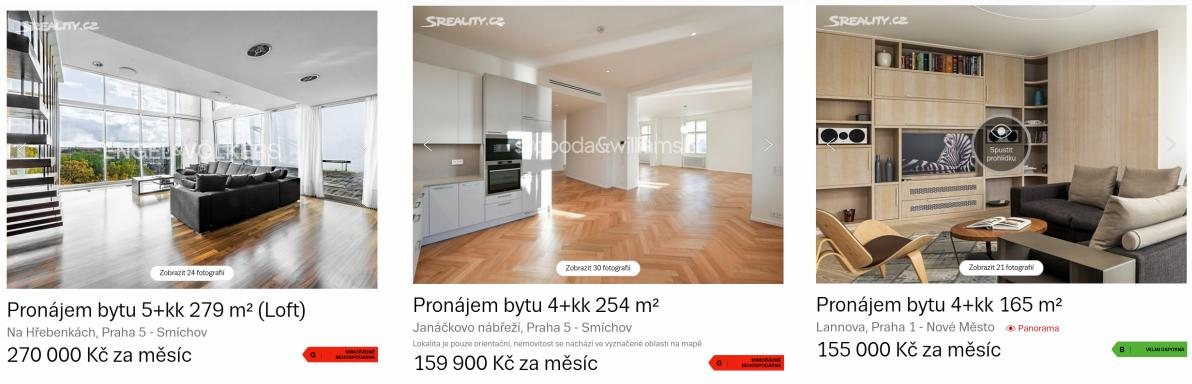)

I stand corrected - these datapoints aren't errorneous, there are just people with much more money than I would expect.

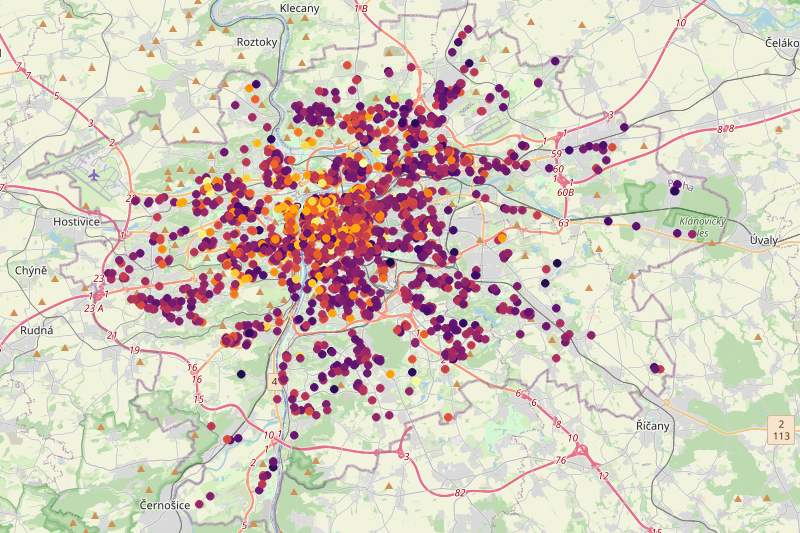

In [8]:
from staticmap import StaticMap, CircleMarker
import matplotlib
import numpy as np

def get_map(df):
    m = StaticMap(800, 533)

    color_scale = matplotlib.colormaps['inferno']

    for index, row in df.iterrows():
        point = CircleMarker((row['locality_gps_lon'], row['locality_gps_lat']), color=tuple(np.floor(np.array(color_scale((row['price_summary_czk'] / df['price_summary_czk'].max())))[0:3] * 255).astype(int)), width=8)
        m.add_marker(point)

    return m.render(zoom=11)

get_map(df[df['price_summary_czk'] < 50000])

In [10]:
df['price_per_sqm'] = df['price_summary_czk'] / df['usable_area']

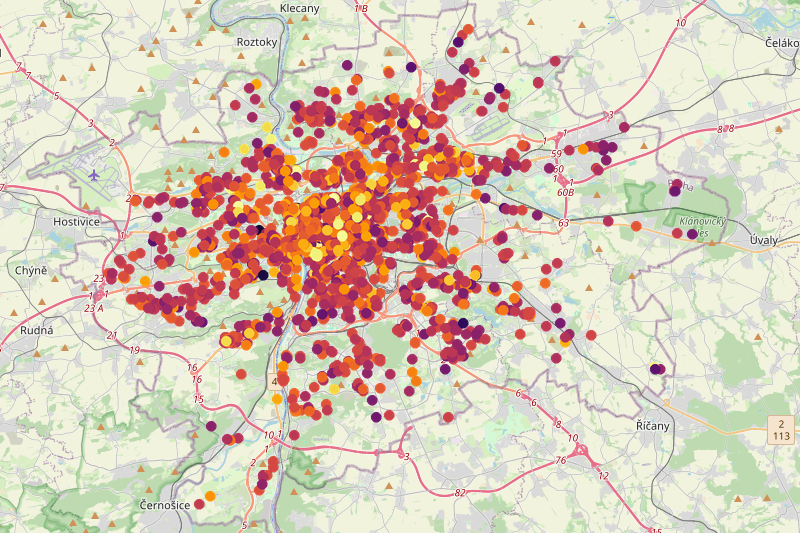

In [11]:
def get_map(df):
    m = StaticMap(800, 533)

    color_scale = matplotlib.colormaps['inferno']

    for index, row in df.iterrows():
        point = CircleMarker((row['locality_gps_lon'], row['locality_gps_lat']), color=tuple(np.floor(np.array(color_scale((row['price_per_sqm'] / df['price_per_sqm'].max())))[0:3] * 255).astype(int)), width=10)
        m.add_marker(point)

    return m.render(zoom=11)

get_map(df[df['price_per_sqm'] < 700])